# Generative Model for predicting the number of leads

## Introduction
We want to predict the number of leads (buying a product), based on the number of people that arrived on the product's landing page.


## Mathmatical modelling
![Model to predict the number of leads](https://user-images.githubusercontent.com/1684807/29458846-5e64179c-8421-11e7-979f-8b041e8c4826.png)
Let's consider:

lead = a customer that arrives on the landing page, who buy the product.

* X = 0 no lead
* X = 1 a lead

And for n experiments of X:
* Y = k, number of successes (leads) of n experiments of X

X is following a Bernouilli distribution. Then Y is following a Binomiale distribution.

## Helper definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_train_test(data):
    # around 20% of the population. Found Manually.
    data_train = data[data["Date"] <= "2015-03-19"]
    data_test = data[data["Date"] > "2015-03-19"]
    
    split_percentage = len(data_train) * 100 / (len(data_train) + len(data_test)) 
    print "INFO - percentage of the data in training set: " + str(split_percentage) + "%"
    
    return data_train, data_test

In [3]:
from scipy.stats import binom


class BinomialePredictor:
    def fit_transform(self, p, n):
        self.__fit__(p)
        return self.__transform__(n)
                
    def __fit__(self, p):
        self.p = p

    def __transform__(self, n):
        return binom.rvs(n, self.p)    

    
# Usage examples    
clicks = pd.Series([100, 10])
leads = pd.Series([10, 1])

bp = BinomialePredictor()
bp.fit_transform(0.1, 1000)

86

## Data Modelling

Data will be grouped by product ("Ad_group_ID"); then a Binomial model will be trained on each product; and then predictions will be done for each according to the model.

In [4]:
# Import data
data = pd.read_csv("./sem-database.csv")

In [5]:
# Define "Leads" Feature
data["Leads"] = data["Conversions"]

In [6]:
# Split in train & test datasets
data_train, data_test = split_train_test(data)

INFO - percentage of the data in training set: 80%


In [7]:
# Create model by Product
g_data = data_train.groupby("Ad_group_ID")

population = g_data["Ad_group_ID"].count()
clicks = g_data["Clicks"].sum()
conversions = g_data["Conversions"].sum()
conversion_rate = conversions.apply(float) / clicks
model = pd.DataFrame(data={"Clicks": clicks, "Population": population, "Conversions": conversions, "Conversion_Rate": conversion_rate})

model.head()

,Clicks,Conversion_Rate,Conversions,Population
Ad_group_ID,,,,
2179346,18,0.0,0,9
7341258,18,0.0,0,6
14545463,2,0.0,0,1
15487922,14,0.0,0,7
16641176,2,0.0,0,1


In [8]:
# Delete outliers: conversion rate over 100%
outliers = model[model["Conversion_Rate"] > 1]
data_test = data_test[~data_test["Ad_group_ID"].isin([outliers.index])]

# Delete unpredictable: it does not make sense to predict if no data in the past
data_test = data_test[data_test["Ad_group_ID"].isin([data_train["Ad_group_ID"].unique()])]

## Predictions

In [9]:
binomiale_predictor = BinomialePredictor()
def predict(row):
    mean = model.loc[row["Ad_group_ID"], "Conversion_Rate"]
    clicks = row["Clicks"]
    return binomiale_predictor.fit_transform(mean, clicks)

In [10]:
data_test["Predictions"] = data_test.apply(predict, axis=1)

## Evaluation

In [11]:
data_eval = data_test

In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(data_eval["Leads"], data_eval["Predictions"])
std = data_eval["Leads"].std()

print "Mean Absolute error: " + str(mae)
print "Standard Deviatio: " + str(std)

Mean Absolute error: 0.0914547777275
Standard Deviatio: 0.558158716461


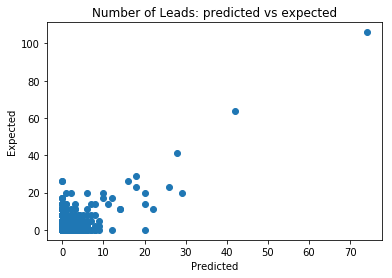

In [13]:
# Check if we have a regression between predicted and expected data
data_plot = data_eval.sample(frac=0.1)
plt.scatter(data_plot["Predictions"], data_plot["Leads"])
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.title("Number of Leads: predicted vs expected")
plt.show()

## Conclusion

1. The mean absolute error is under the standard deviation: it is acceptable
2. The model is a bit random under 10 clicks
3. Above 10 clicks, we can see a regression between predicted and expected data: this is a good sign for a model


**Improvements**

We need a more complex model to improve predictions for 0 ; 10 clicks